# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
!pip install tqdm pandarallel transformers wordcloud ipywidgets Pillow

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [55]:
import pandas as pd
import transformers
import numpy as np
import torch

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

import tensorflow as tf
from PIL import Image

from os import listdir
from transformers import AutoFeatureExtractor, ResNetForImageClassification

from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, AvgPool2D, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm

tqdm.pandas()

In [56]:
ORIGINAL_DIR = './original'

## Подготовка данных разметки

In [57]:
crowd_annotations = pd.read_csv(f'{ORIGINAL_DIR}/CrowdAnnotations.tsv', delimiter='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'percent', 'positive', 'negative']

In [6]:
expert_annotations = pd.read_csv(f'{ORIGINAL_DIR}/ExpertAnnotations.tsv', delimiter='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'expert_0', 'expert_1', 'expert_2']

In [7]:
def get_expert(record):
    marks = [0, 0, 0, 0]
     
    marks[record['expert_0'] - 1] += 1
    marks[record['expert_1'] - 1] += 1
    marks[record['expert_2'] - 1] += 1

    for i in range(len(marks)):
        if (marks[i] == 2) | (marks[i] == 3):
            return i + 1

    return 0

expert_annotations['mark'] = expert_annotations.apply(get_expert, axis=1)

In [8]:
expert_annotations = expert_annotations[expert_annotations['mark'] > 0]

In [9]:
expert_annotations['percent_expert'] = expert_annotations['mark'] / 4

In [10]:
expert_annotations

,image,query_id,expert_0,expert_1,expert_2,mark,percent_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1,0.25
...,...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1,0.25
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.25
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.25
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1,0.25


In [11]:
crowd_annotations['sum'] = crowd_annotations['positive'] + crowd_annotations['negative']

In [12]:
crowd_annotations['percent_crowd'] = crowd_annotations['positive'] / crowd_annotations['sum']

In [13]:
crowd_annotations

,image,query_id,percent,positive,negative,sum,percent_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0,3,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3,3,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3,3,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3,3,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3,3,0.000000
...,...,...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3,3,0.000000
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2,3,0.333333
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0,3,1.000000
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3,3,0.000000


In [14]:
expert_annotations

,image,query_id,expert_0,expert_1,expert_2,mark,percent_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1,0.25
...,...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1,0.25
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.25
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.25
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1,0.25


In [15]:
marks = crowd_annotations.merge(expert_annotations, on=['query_id', 'image'])[['image', 'query_id', 'percent_crowd', 'percent_expert']]

## Данные о фотографиях.

In [16]:
test_images = pd.read_csv(f'{ORIGINAL_DIR}/test_images.csv')
test_queries = pd.read_csv(f'{ORIGINAL_DIR}/test_queries.csv', delimiter='|', index_col=[0])
train_dataset = pd.read_csv(f'{ORIGINAL_DIR}/train_dataset.csv')

In [17]:
test_images.sample(10)

,image
9,634891010_9fa189effb.jpg
26,989754491_7e53fb4586.jpg
91,3036971334_78187a9570.jpg
4,1177994172_10d143cb8d.jpg
67,3482859574_3908de3427.jpg
54,2714674623_8cd05ac114.jpg
7,3396275223_ee080df8b5.jpg
73,2737233999_34d60dc5c3.jpg
8,2977379863_2e8d7a104e.jpg
32,3030079705_0dee8a3e89.jpg


In [18]:
test_queries.sample(10)

,query_id,query_text,image
207,3036971334_78187a9570.jpg#2,Four people are cavorting on the rocks at a ri...,3036971334_78187a9570.jpg
137,2552438538_285a05b86c.jpg#2,Three children stand on or near a fence .,2552438538_285a05b86c.jpg
236,3122579598_14841c038a.jpg#1,Two boys and a white dog stand in a park .,3122579598_14841c038a.jpg
428,381514859_b40418d9c3.jpg#3,Two West Highland Terriers chase a red ball .,381514859_b40418d9c3.jpg
89,2346402952_e47d0065b6.jpg#4,Two women reviewing pictures they took .,2346402952_e47d0065b6.jpg
366,3487131146_9d3aca387a.jpg#1,A race car kicks up dirt and dust on a gravel ...,3487131146_9d3aca387a.jpg
261,3173157541_70b16b4318.jpg#1,"A man with a white hat and brown shirt , behin...",3173157541_70b16b4318.jpg
359,3466891862_9afde75568.jpg#4,The small fluffy white dog runs through the gr...,3466891862_9afde75568.jpg
402,3601978895_9fec23ce0c.jpg#2,Two men are standing under what looks to be a ...,3601978895_9fec23ce0c.jpg
454,607339469_af851c4119.jpg#4,Little girl feeds the ducks .,607339469_af851c4119.jpg


In [19]:
train_dataset.sample(10)

,image,query_id,query_text
4088,3270691950_88583c3524.jpg,1523984678_edd68464da.jpg#2,Small black and white dog wearing a red harnes...
3526,3388330419_85d72f7cda.jpg,370713359_7560808550.jpg#2,"Crowded Mexican restaurant , empty chair in fo..."
4874,3030566410_393c36a6c5.jpg,3605676864_0fb491267e.jpg#2,Children play in an inflatable pool .
2913,430173345_86388d8822.jpg,327415627_6313d32a64.jpg#2,Two dogs run through a field .
4913,3387542157_81bfd00072.jpg,3051384385_c5c850c1f8.jpg#2,a young child balancing a plate in the air on ...
2208,3702436188_2c26192fd0.jpg,2949982320_c704b31626.jpg#2,A man is doing tricks with a bicycle at a skat...
4950,3325497914_f9014d615b.jpg,3657016761_d553e514d9.jpg#2,A young girl stands under three large rings th...
4650,3254817653_632e840423.jpg,1282392036_5a0328eb86.jpg#2,Two woman in colorful costumes look at a littl...
1931,2542662402_d781dd7f7c.jpg,3048597471_5697538daf.jpg#2,A dog wading in the water with a ball in his m...
356,3145967309_b33abe4d84.jpg,3044500219_778f9f2b71.jpg#2,Four woman wearing formal gowns pose together ...


In [20]:
test_images.info()
print()
test_queries.info()
print()
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [21]:
len(test_queries['image'].unique())

100

In [22]:
len(train_dataset['image'].unique())

1000

In [23]:
test_queries['type'] = 'test'
train_dataset['type'] = 'train'
data = pd.concat([test_queries, train_dataset]).reset_index(drop=True)

In [24]:
len(data['image'].unique())

1100

Проверим test_images и test_queries, соответствуют ли данные, если да то test_images не нужны.

In [25]:
test_queries[test_queries['image'].isin(test_images['image'])]

,query_id,query_text,image,type
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,test
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,test
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,test
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,test
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,test
...,...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg,test
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg,test
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg,test
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg,test


In [26]:
test_images[test_images['image'].isin(test_queries['image'].unique())]

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
...,...
95,2431120202_b24fe2333a.jpg
96,2399219552_bbba0a9a59.jpg
97,3091962081_194f2f3bd4.jpg
98,2670637584_d96efb8afa.jpg


Значит датасеты совпадают

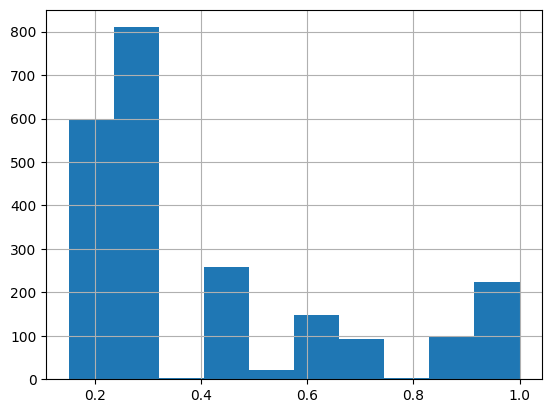

In [27]:
def get_mark(record):
    return record['percent_crowd'] * 0.4 + record['percent_expert'] * 0.6

marks['target'] = marks.apply(get_mark, axis=1)
marks['target'].hist()
None

In [28]:
data['type'].value_counts()

type
train    5822
test      500
Name: count, dtype: int64

In [29]:
df = marks.merge(data, on=['query_id', 'image'], how='right')
df.sample(10)

,image,query_id,percent_crowd,percent_expert,target,query_text,type
1616,1287073593_f3d2a62455.jpg,247637795_fdf26a03cf.jpg#2,NaN,NaN,NaN,A woman holding a black leash and a man lookin...,train
4624,505929313_7668f021ab.jpg,3437147889_4cf26dd525.jpg#2,NaN,NaN,NaN,Two motocross riders next to each other on a d...,train
5463,3484832904_08619300d9.jpg,3514179514_cbc3371b92.jpg#2,NaN,NaN,NaN,A baseman tries to catch a ball while a runner...,train
1146,2197275664_fabcf3424b.jpg,3243588540_b418ac7eda.jpg#2,NaN,NaN,NaN,The girl is standing as the other girl with gl...,train
2205,2194494220_bb2178832c.jpg,2176980976_7054c99621.jpg#2,0.0,0.50,0.30,Several people on top of a mountain look down ...,train
5543,2505988632_9541f15583.jpg,534875358_6ea30d3091.jpg#2,NaN,NaN,NaN,A woman in patterned blue jeans and a green sw...,train
3160,3347798761_5c5260b000.jpg,2256133102_e2c8314ecb.jpg#2,NaN,NaN,NaN,An individual rappelling down a cliff towards ...,train
5853,2718495608_d8533e3ac5.jpg,2905942129_2b4bf59bc0.jpg#2,NaN,NaN,NaN,The two children swinging together on a swing .,train
1527,537559285_29be110134.jpg,3514019869_7de4ece2a5.jpg#2,1.0,1.00,1.00,A dog jumps over an obstacle .,train
3061,463978865_c87c6ca84c.jpg,260520547_944f9f4c91.jpg#2,0.0,0.75,0.45,People walking down a sidewalk on a beach .,train


In [30]:
df = df[(~df['percent_crowd'].isna()) | (df['type'] == 'test')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2758 entries, 0 to 6320
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           2758 non-null   object 
 1   query_id        2758 non-null   object 
 2   percent_crowd   2258 non-null   float64
 3   percent_expert  2258 non-null   float64
 4   target          2258 non-null   float64
 5   query_text      2758 non-null   object 
 6   type            2758 non-null   object 
dtypes: float64(3), object(4)
memory usage: 172.4+ KB


## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [31]:
MAX_LENGTH = max(df['query_text'].apply(lambda x: len(x)))
print(MAX_LENGTH)

153


In [32]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

illegal_ids = tokenizer.encode(
    ' '.join(['boy', 'boys', 'girl', 'girls', 'young', 'child', 'children']), 
    truncation=True, 
    max_length=MAX_LENGTH, 
    add_special_tokens=True
)

def tokenize(text, tokenizer, max_length, illegal_ids):
    ids = tokenizer.encode(
        text, 
        truncation=True, 
        max_length=max_length, 
        add_special_tokens=True
    )
    print(ids, illegal_ids)
    if len(list(set(ids) & set(illegal_ids))) == 2:
        return ids
    else:
        return None

def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    padded = torch.LongTensor(padded)  
    attention_mask = torch.LongTensor(attention_mask)

    return padded, attention_mask

In [33]:
tokenized = df['query_text'].parallel_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH, illegal_ids=illegal_ids)

tokenized = tokenized.dropna()

padded, attention_mask = get_padded_mask(tokenized)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [34]:
df = df.loc[tokenized.index]
df['input_ids'] = padded.tolist()
df['attention_mask'] = attention_mask.tolist()

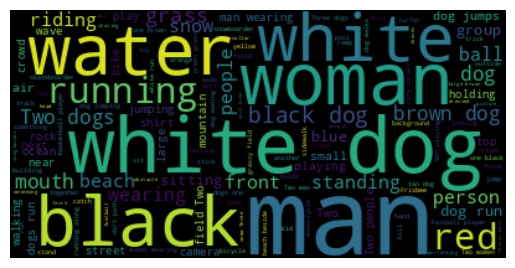

In [35]:
wordcloud = WordCloud().generate(' '.join(df['query_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
df = df.reset_index(drop=True)

In [37]:
df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids,attention_mask
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test,"[101, 2195, 2931, 13488, 2867, 2024, 2183, 204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,NaN,NaN,NaN,The woman lacrosse player in blue is about to ...,test,"[101, 1996, 2450, 13488, 2447, 1999, 2630, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,NaN,NaN,NaN,Women play lacrosse .,test,"[101, 2308, 2377, 13488, 1012, 102, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,NaN,NaN,NaN,A brown dog is sitting in some long grass .,test,"[101, 1037, 2829, 3899, 2003, 3564, 1999, 2070...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#1,NaN,NaN,NaN,A brown dog sits still on a hillside .,test,"[101, 1037, 2829, 3899, 7719, 2145, 2006, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
2103,415793623_6c1225ae27.jpg,2554081584_233bdf289a.jpg#2,0.0,0.50,0.30,a man wearing a yellow shirt and white hardhat...,train,"[101, 1037, 2158, 4147, 1037, 3756, 3797, 1998...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2104,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,0.0,0.25,0.15,A man and a woman sitting on a dock .,train,"[101, 1037, 2158, 1998, 1037, 2450, 3564, 2006...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
2105,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,0.0,0.50,0.30,A man stands at the entrance of Yerba Buena Ce...,train,"[101, 1037, 2158, 4832, 2012, 1996, 4211, 1997...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2106,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,0.0,0.25,0.15,Two men in black jackets behind a white handra...,train,"[101, 2048, 2273, 1999, 2304, 17764, 2369, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."


## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [38]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.__version__

Num GPUs Available:  1


'2.10.0'

In [39]:
model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3), pooling='max')

def read_img_file(f):
    img = Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def resize_img_to_array(img, img_shape):
    img_array = np.array(
        img.resize(
            img_shape,
            Image.LANCZOS
        )
    )    
    return img_array

def get_features(img):
    img_width, img_height = 224, 224
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    expanded_img_array = np.expand_dims(np_img, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    X_conv = model.predict(preprocessed_img, verbose=0)
    # return X_conv
    image_features=X_conv[0]
    image_features /=  np.linalg.norm(image_features)
    return image_features
    

2023-08-18 19:12:50.238922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 19:12:50.240044: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3070)
2023-08-18 19:12:50.431886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-18 19:12:50.431931: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-08-18 19:12:50.431953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [40]:
images = pd.DataFrame(listdir(f'{ORIGINAL_DIR}/images'), columns=['image'])
images = images[images['image'] != '.DS_Store']

In [41]:
def read_img_features(filename, ORIGINAL_DIR=ORIGINAL_DIR, get_features=get_features):
    image = Image.open(f'{ORIGINAL_DIR}/images/{filename}')
    return get_features(image)

In [42]:
images['tensor'] = images['image'].progress_apply(read_img_features, ORIGINAL_DIR=ORIGINAL_DIR, get_features=get_features)

100%|██████████| 1100/1100 [01:34<00:00, 11.70it/s]


## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [50]:
df = df.merge(images, on=['image'])

In [52]:
df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids,attention_mask,tensor
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test,"[101, 2195, 2931, 13488, 2867, 2024, 2183, 204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,NaN,NaN,NaN,The woman lacrosse player in blue is about to ...,test,"[101, 1996, 2450, 13488, 2447, 1999, 2630, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,NaN,NaN,NaN,Women play lacrosse .,test,"[101, 2308, 2377, 13488, 1012, 102, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
3,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,NaN,NaN,NaN,A brown dog is sitting in some long grass .,test,"[101, 1037, 2829, 3899, 2003, 3564, 1999, 2070...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.00822476, 0.014956112, 0.012222196, 0.01061..."
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#1,NaN,NaN,NaN,A brown dog sits still on a hillside .,test,"[101, 1037, 2829, 3899, 7719, 2145, 2006, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0.00822476, 0.014956112, 0.012222196, 0.01061..."
...,...,...,...,...,...,...,...,...,...,...
2103,3191135894_2b4bdabb6d.jpg,1490213660_9ea45550cf.jpg#2,0.000000,0.25,0.150000,A male weimaraner with a clipped tail is walki...,train,"[101, 1037, 3287, 20695, 7231, 2099, 2007, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0045584976, 0.006491686, 0.008002392, 0.037..."
2104,3399284917_721aefe2a7.jpg,3085667865_fa001816be.jpg#2,0.000000,0.25,0.150000,A person in a wetsuit is in midair while surfi...,train,"[101, 1037, 2711, 1999, 1037, 4954, 28880, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.008116325, 0.016763875, 0.0, 0.038178343, 0..."
2105,3484832904_08619300d9.jpg,3542484764_77d8920ec9.jpg#2,0.666667,0.75,0.716667,The cricketer is swinging a bat in the air .,train,"[101, 1996, 9490, 2003, 11820, 1037, 7151, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.011006555, 0.012909047, 0.0, 0.03232149, 0...."
2106,754852108_72f80d421f.jpg,2162564553_96de62c7e6.jpg#2,0.000000,0.50,0.300000,A shirtless man in a pink hat stands on a rock...,train,"[101, 1037, 3797, 3238, 2158, 1999, 1037, 5061...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.006191542, 0.025581887, 0.0026996569, 0.013..."


## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [59]:
df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids,attention_mask,tensor
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,NaN,NaN,NaN,Several female lacrosse players are going afte...,test,"[101, 2195, 2931, 13488, 2867, 2024, 2183, 204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,NaN,NaN,NaN,The woman lacrosse player in blue is about to ...,test,"[101, 1996, 2450, 13488, 2447, 1999, 2630, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,NaN,NaN,NaN,Women play lacrosse .,test,"[101, 2308, 2377, 13488, 1012, 102, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.023832401, 0.03071706, 0.0, 0.022547793, 0...."
3,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,NaN,NaN,NaN,A brown dog is sitting in some long grass .,test,"[101, 1037, 2829, 3899, 2003, 3564, 1999, 2070...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.00822476, 0.014956112, 0.012222196, 0.01061..."
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#1,NaN,NaN,NaN,A brown dog sits still on a hillside .,test,"[101, 1037, 2829, 3899, 7719, 2145, 2006, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0.00822476, 0.014956112, 0.012222196, 0.01061..."
...,...,...,...,...,...,...,...,...,...,...
2103,3191135894_2b4bdabb6d.jpg,1490213660_9ea45550cf.jpg#2,0.000000,0.25,0.150000,A male weimaraner with a clipped tail is walki...,train,"[101, 1037, 3287, 20695, 7231, 2099, 2007, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0045584976, 0.006491686, 0.008002392, 0.037..."
2104,3399284917_721aefe2a7.jpg,3085667865_fa001816be.jpg#2,0.000000,0.25,0.150000,A person in a wetsuit is in midair while surfi...,train,"[101, 1037, 2711, 1999, 1037, 4954, 28880, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.008116325, 0.016763875, 0.0, 0.038178343, 0..."
2105,3484832904_08619300d9.jpg,3542484764_77d8920ec9.jpg#2,0.666667,0.75,0.716667,The cricketer is swinging a bat in the air .,train,"[101, 1996, 9490, 2003, 11820, 1037, 7151, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.011006555, 0.012909047, 0.0, 0.03232149, 0...."
2106,754852108_72f80d421f.jpg,2162564553_96de62c7e6.jpg#2,0.000000,0.50,0.300000,A shirtless man in a pink hat stands on a rock...,train,"[101, 1037, 3797, 3238, 2158, 1999, 1037, 5061...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.006191542, 0.025581887, 0.0026996569, 0.013..."


In [67]:
valid_df = df[df['type'] == 'test']

In [80]:
train_test_df = df[df['type'] == 'train'].reset_index(drop=True)

In [81]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=train_test_df[['input_ids', 'attention_mask', 'tensor']], y=train_test_df['target'], groups=train_test_df['image']))
train_df, test_df = train_test_df.loc[train_indices], train_test_df.loc[test_indices]

In [84]:
train_test_df

,image,query_id,percent_crowd,percent_expert,target,query_text,type,input_ids,attention_mask,tensor
0,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,0.000000,0.50,0.300000,A man sleeps under a blanket on a city street .,train,"[101, 1037, 2158, 25126, 2104, 1037, 8768, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0.0076262807, 0.02530054, 0.00066639687, 0.02..."
1,463978865_c87c6ca84c.jpg,260520547_944f9f4c91.jpg#2,0.000000,0.75,0.450000,People walking down a sidewalk on a beach .,train,"[101, 2111, 3788, 2091, 1037, 11996, 2006, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0.0076262807, 0.02530054, 0.00066639687, 0.02..."
2,370713359_7560808550.jpg,3207358897_bfa61fa3c6.jpg#2,0.000000,0.25,0.150000,A woman plays with long red ribbons in an empt...,train,"[101, 1037, 2450, 3248, 2007, 2146, 2417, 2268...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0.0059671476, 0.016198676, 0.02589408, 0.0389..."
3,2101457132_69c950bc45.jpg,3286822339_5535af6b93.jpg#2,0.000000,0.25,0.150000,Chinese market street in the winter time .,train,"[101, 2822, 3006, 2395, 1999, 1996, 3467, 2051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0.010596734, 0.025804726, 0.023625495, 0.0075..."
4,2101457132_69c950bc45.jpg,3435035138_af32890a4c.jpg#2,0.000000,0.50,0.300000,A shaggy dog runs down a dirt trail in a lush ...,train,"[101, 1037, 25741, 3899, 3216, 2091, 1037, 690...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.010596734, 0.025804726, 0.023625495, 0.0075..."
...,...,...,...,...,...,...,...,...,...,...
1758,3191135894_2b4bdabb6d.jpg,1490213660_9ea45550cf.jpg#2,0.000000,0.25,0.150000,A male weimaraner with a clipped tail is walki...,train,"[101, 1037, 3287, 20695, 7231, 2099, 2007, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0045584976, 0.006491686, 0.008002392, 0.037..."
1759,3399284917_721aefe2a7.jpg,3085667865_fa001816be.jpg#2,0.000000,0.25,0.150000,A person in a wetsuit is in midair while surfi...,train,"[101, 1037, 2711, 1999, 1037, 4954, 28880, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.008116325, 0.016763875, 0.0, 0.038178343, 0..."
1760,3484832904_08619300d9.jpg,3542484764_77d8920ec9.jpg#2,0.666667,0.75,0.716667,The cricketer is swinging a bat in the air .,train,"[101, 1996, 9490, 2003, 11820, 1037, 7151, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.011006555, 0.012909047, 0.0, 0.03232149, 0...."
1761,754852108_72f80d421f.jpg,2162564553_96de62c7e6.jpg#2,0.000000,0.50,0.300000,A shirtless man in a pink hat stands on a rock...,train,"[101, 1037, 3797, 3238, 2158, 1999, 1037, 5061...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.006191542, 0.025581887, 0.0026996569, 0.013..."


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска